<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/day1_ex01_fid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free induction decay (FID) sequence

In [1]:
#@title FID in a pixel phantom - environment setup
!pip install MRzeroCore &> /dev/null
!pip install pypulseq==1.4.1 &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int=int
np.float=float
np.complex=complex

import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt
import util

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


In [2]:
#@title FID in a pixel phantom - sequence
# %% DEFINE the sequence, FOV and resolution
seq=pp.Sequence()
fov=1000e-3
Nread=256
Nphase=1
Nrep=1 # repeat the fid sequence mutiple times

experiment_id = 'FID'
# %% SETUP system
# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6)

# Define rf event
# hard pulse for excitation
rf_ex = pp.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)
#rf_ex.delay = 12e-3 - pp.calc_duration(rf_ex) # create a delay to make ADC start at 12 ms.

# Define ADC event
adc = pp.make_adc(num_samples=Nread, duration=60e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)

#Trec=3 # set the recovery time
# ======
# CONSTRUCT SEQUENCE
# ======
for i in range(Nrep):
  seq.add_block(rf_ex)
  seq.add_block(adc)
  #seq.add_block(pp.make_delay(Trec)) # add a recovery delay here

/usr/local/lib/python3.10/dist-packages/pypulseq/Sequence/write_seq.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arb_grad_mask = grad_lib_values == "g"
/usr/local/lib/python3.10/dist-packages/pypulseq/Sequence/write_seq.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  trap_grad_mask = grad_lib_values == "t"
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


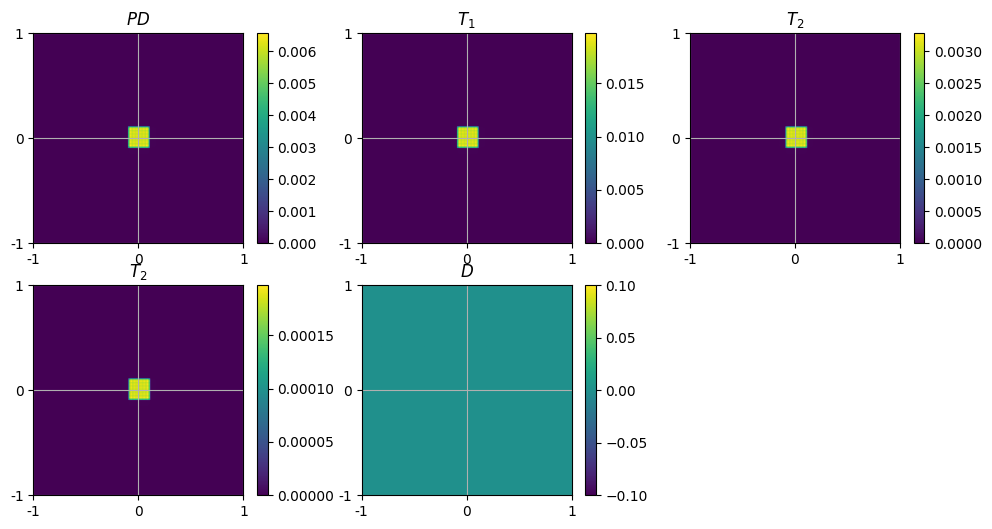

Some sections were ignored: ['SIGNATURE']
Calculating repetition 1 / 1 - done


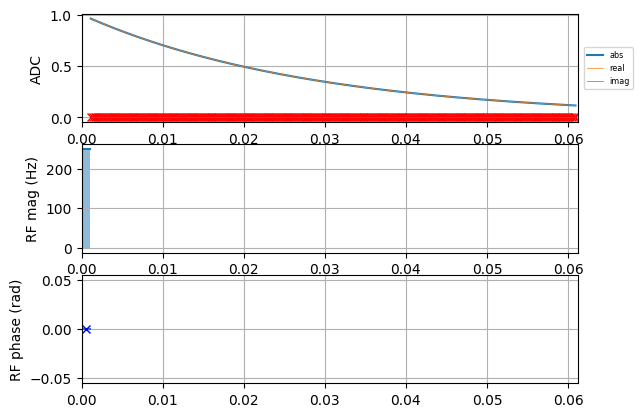

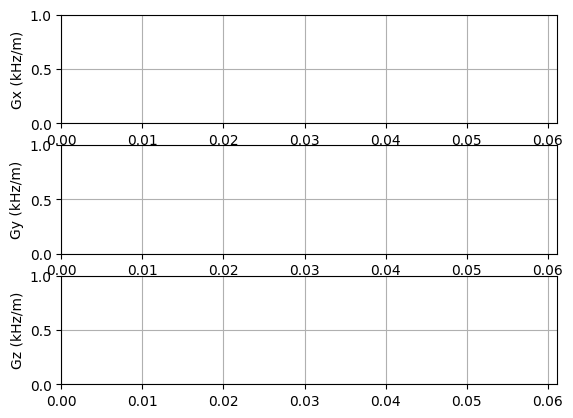

In [3]:
#@title FID in a pixel phantom - simulation
# Prepare the sequence output for the scanner
seq.set_definition('Name', 'fid')
seq.write('day1_ex01_fid.seq')
#@markdown  The B0 inhomogeneity brings you from the rotating frame FID at dB0=0, closer to the lab frame FID at dB0=B0.
#@markdown Try dB0=0 and dB0=500 for a test.
dB0 = 0 #@param {title:'dB0',type:"slider", min:0, max:500, step:10}
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
obj_p = mr0.CustomVoxelPhantom(
        pos=[[0., 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.from_seq_file("day1_ex01_fid.seq")
# seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p)
# PLOT sequence with SIGNAL
sp_adc, t_adc = util.pulseq_plot(seq=seq,signal=signal.numpy())

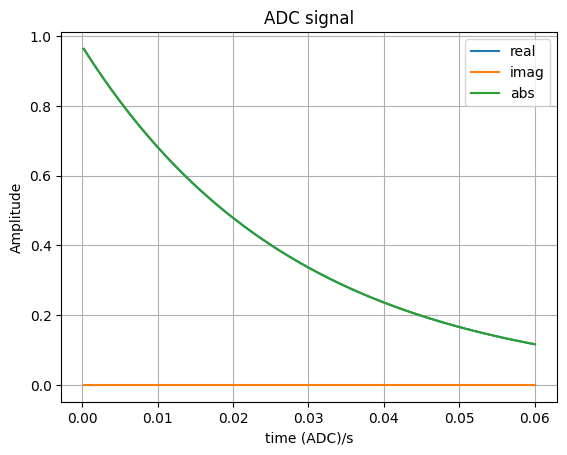

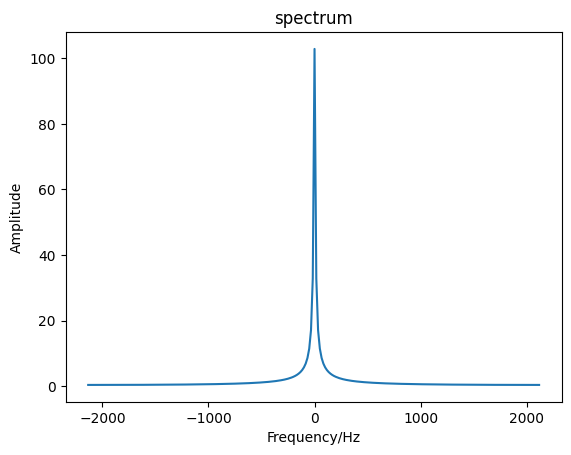

In [4]:
#@title FID in a pixel phantom - reconstruction
# 1D FFT
def fft_1d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

# detailed ADC plot for one repetition
if Nrep==1:
  plt.figure()
  plt.title('ADC signal')
  # time axis
  time_axis=np.linspace(1, Nread, Nread)*adc.dwell ;
  plt.plot(time_axis, np.real(signal), label='real')
  plt.plot(time_axis, np.imag(signal), label='imag')
  plt.plot(time_axis, np.abs(signal), label='abs')
  plt.grid()
  plt.legend(loc="upper right")
  plt.xlabel('time (ADC)/s')
  plt.ylabel('Amplitude')

  # FFT reconstruction
  spectrum = fft_1d(signal)

  # frequency axis
  freq_axis = np.linspace(-Nread/2, Nread/2-1, Nread)/(adc.dwell*adc.num_samples) ; # remain to be checked whether -1 should be included or not

  plt.figure()
  plt.title('spectrum')
  plt.plot(freq_axis, np.abs(spectrum))
  plt.xlabel('Frequency/Hz')
  plt.ylabel('Amplitude')